# Point72 Global Futures Analysis Cumulative Returns

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in Data

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_path = os.path.join(data_path, "prices.parquet")

In [3]:
df_raw = pd.read_parquet(
    path = price_path,
    engine = "pyarrow")

# Roll Adjustment

It doesn't say to do or not account for role adjustment so in this case both will be used. Just use close price. Since there is already a method for it in MarketStats.py, just use that and set ```verbose==True``` to find where the attribute is saved.

Access object

In [4]:
import sys
src_path = os.path.join(parent_path, "src")
sys.path.append(src_path)

from MarketStats import MarketStats
market_stats = MarketStats(price_path, verbose = True)

In [5]:
market_stats.get_roll_adjusted_close()

Roll Adjusted closed saved as attribute df_roll_adj


In [6]:
df_roll_adj = market_stats.df_roll_adj

# Calculating Cumulative Return

In [7]:
df_nyc_input = (df_roll_adj.merge(
    right = df_raw[["local_time", "nyc_time"]],
    how = "inner",
    on = ["local_time"]).
    drop(columns = ["local_time"]))

In [8]:
df_london_nyc = (df_raw.query(
    "zone == 'London'")
    [["local_time", "nyc_time"]].
    rename(columns = {"local_time": "london_time"}))

df_london_map = (df_raw[
    ["nyc_time", "local_time"]].
    merge(right = df_london_nyc, how = "inner", on = ["nyc_time"]).
    drop(columns = ["nyc_time"]))

df_london_input = (df_roll_adj.merge(
    right = df_london_map, how = "inner", on = ["local_time"]).
    drop(columns = ["local_time"]))

In [9]:
def get_cum_rtn(df_input: pd.DataFrame, col_name: str, hour1: int = 9, hour2: int = 12):
    
    df_longer = (df_input.assign(
        hour = lambda x: x[col_name].dt.hour).
        query("hour >= @hour1 & hour <= @hour2").
        drop(columns = ["hour"]).
        groupby(["contract_name", col_name]).
        head(1))
    
    df_wider = (df_longer.melt(
        id_vars = [col_name, "contract_name"], var_name = "roll").
        pivot(index = col_name, columns = ["contract_name", "roll"], values = "value"))
    
    df_cum_longer = (np.cumprod((1 + df_wider.pct_change().dropna())) - 1).reset_index().melt(id_vars = [col_name])
    
    return df_cum_longer

## 10y Cum Returns 2y Lookback Window

In [10]:
df_nyc_cum_rtn = get_cum_rtn(df_nyc_input, "nyc_time")
df_london_cum_rtn = get_cum_rtn(df_london_input, "london_time", hour1 = 8, hour2 = 11)

In [11]:
max_year = df_nyc_cum_rtn.nyc_time.max().date().year
min_year = max_year - 2

In [12]:
df_nyc_cum_rtn = (df_nyc_cum_rtn.assign(
    year = lambda x: x.nyc_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

df_london_cum_rtn = (df_london_cum_rtn.assign(
    year = lambda x: x.london_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

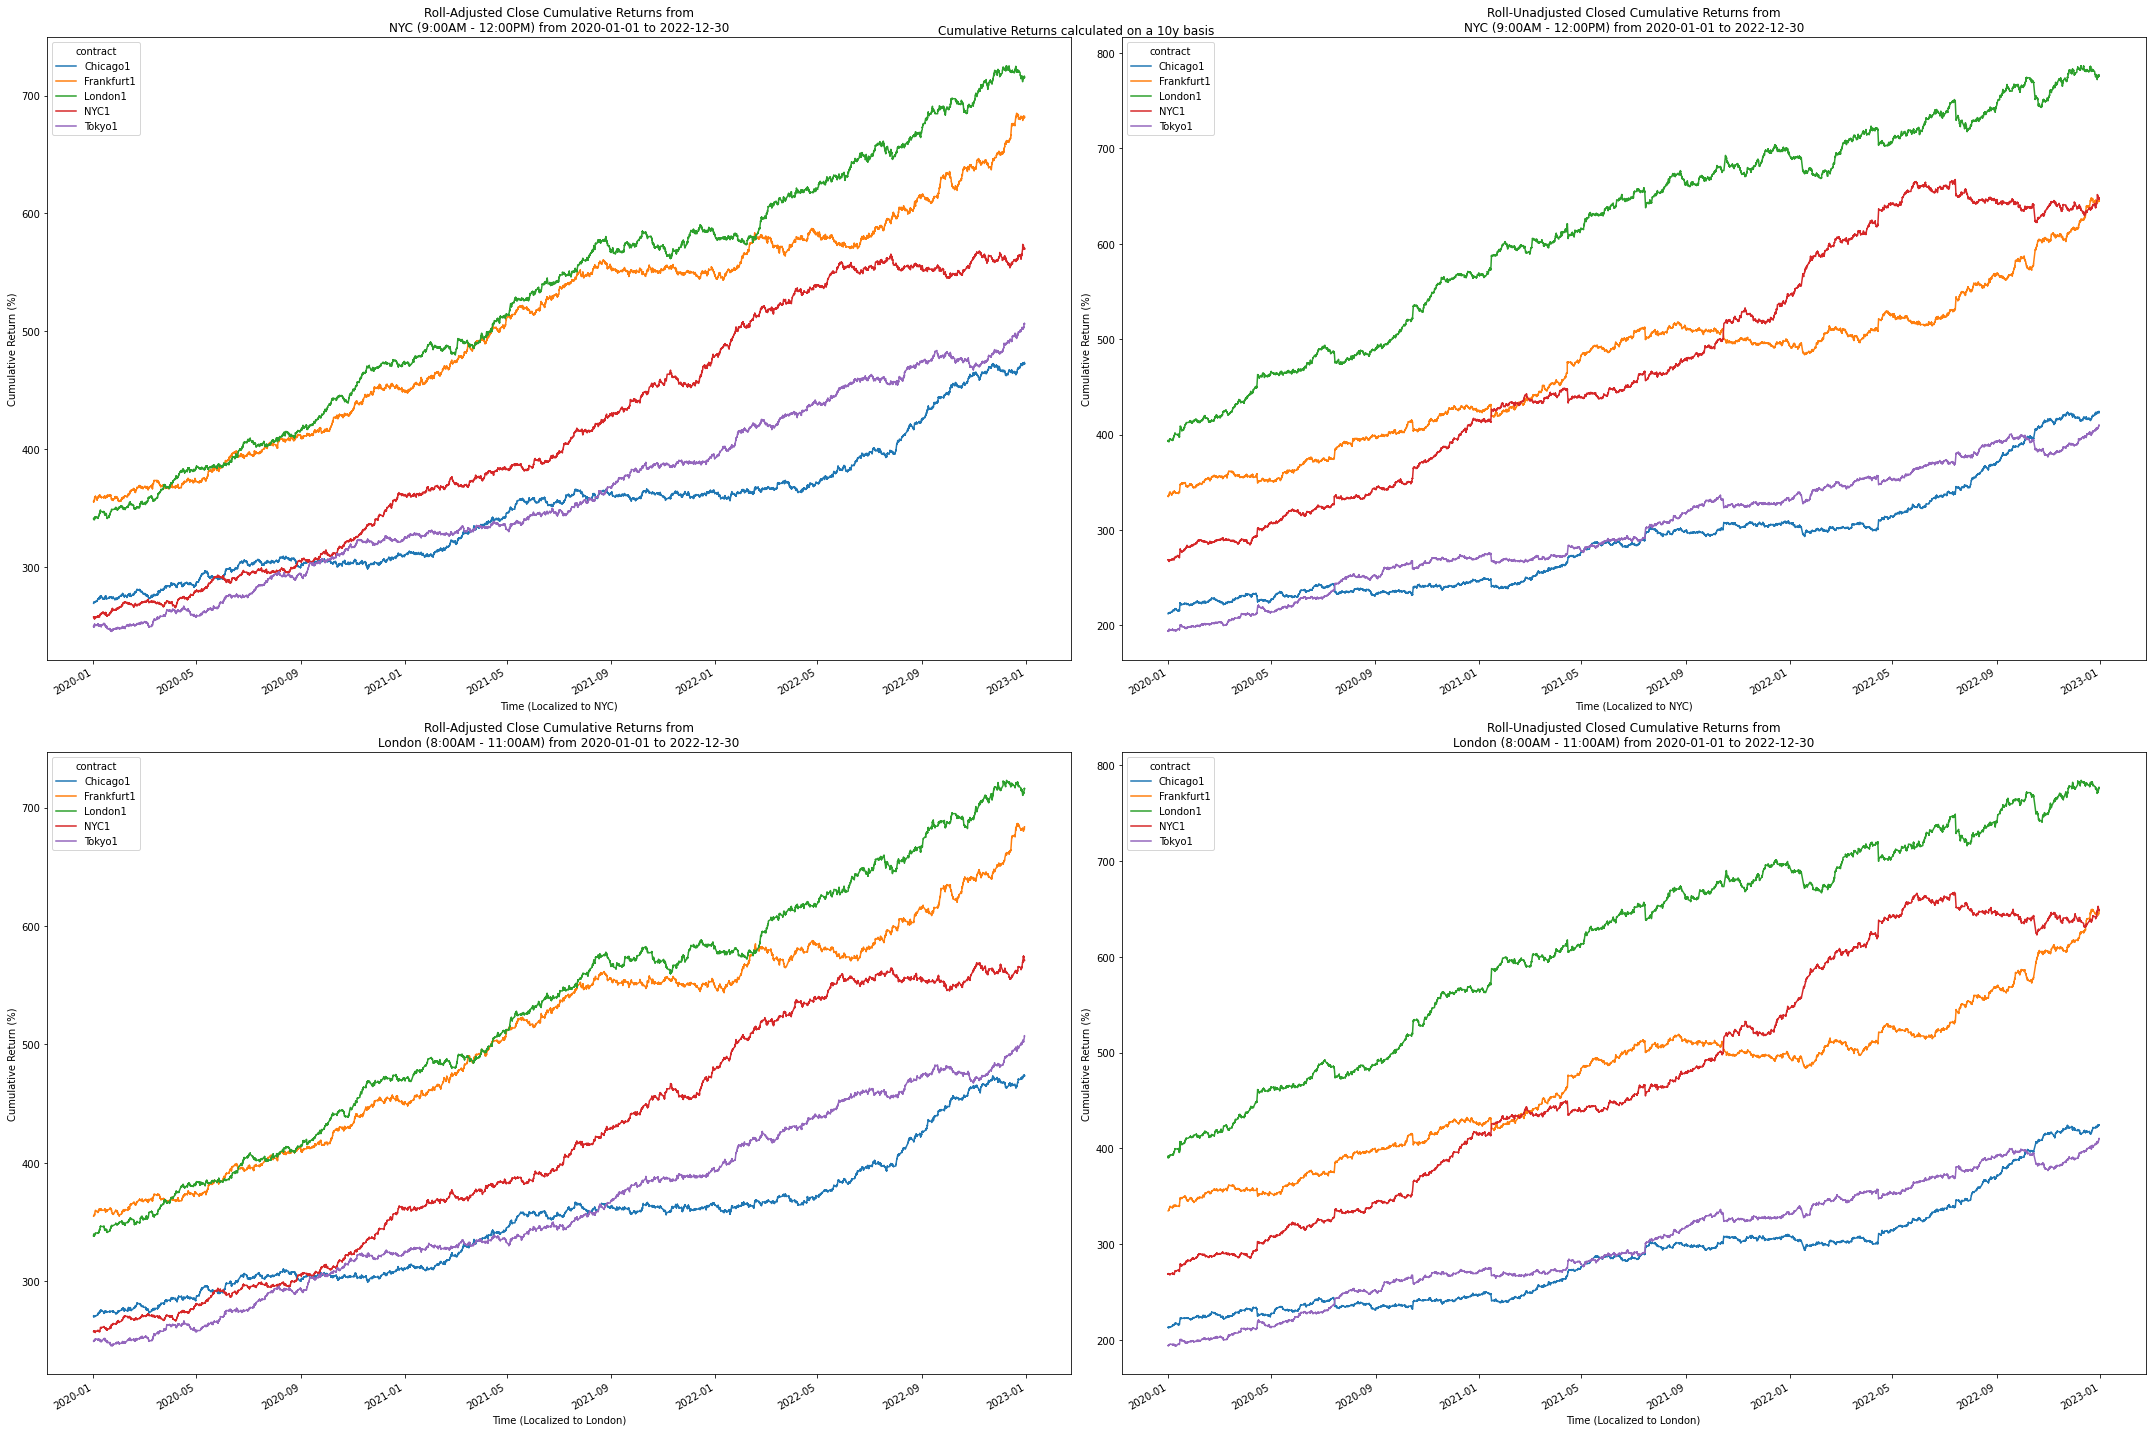

In [13]:
rolls = ["adj", "unadj"]
roll_renamer = {"adj": "Roll-Adjusted Close", "unadj": "Roll-Unadjusted Closed"}
fig, axes = plt.subplots(ncols = len(rolls), nrows = 2, figsize = (30,20))

for i, roll in enumerate(rolls):
    
    (df_nyc_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "nyc_time", columns = "contract", values = "value").
        plot(
            ax = axes[0,i],
            xlabel = "Time (Localized to NYC)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nNYC (9:00AM - 12:00PM) from {} to {}".format(
                roll_renamer[roll],
                df_nyc_cum_rtn.nyc_time.min().date(),
                df_nyc_cum_rtn.nyc_time.max().date())))
    
    (df_london_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "london_time", columns = "contract", values = "value").
        plot(
            ax = axes[1,i],
            xlabel = "Time (Localized to London)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nLondon (8:00AM - 11:00AM) from {} to {}".format(
                roll_renamer[roll],
                df_london_cum_rtn.london_time.min().date(),
                df_london_cum_rtn.london_time.max().date())))
    
fig.suptitle("Cumulative Returns calculated on a 10y basis")
plt.tight_layout()
plt.show()

## 2y Cum Returns 2y Lookback Window

In [14]:
df_nyc_input = (df_nyc_input.assign(
    year = lambda x: x.nyc_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

df_london_input = (df_london_input.assign(
    year = lambda x: x.london_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["year"]))

In [15]:
df_nyc_cum_rtn = get_cum_rtn(df_nyc_input, "nyc_time")
df_london_cum_rtn = get_cum_rtn(df_london_input, "london_time", hour1 = 8, hour2 = 11)

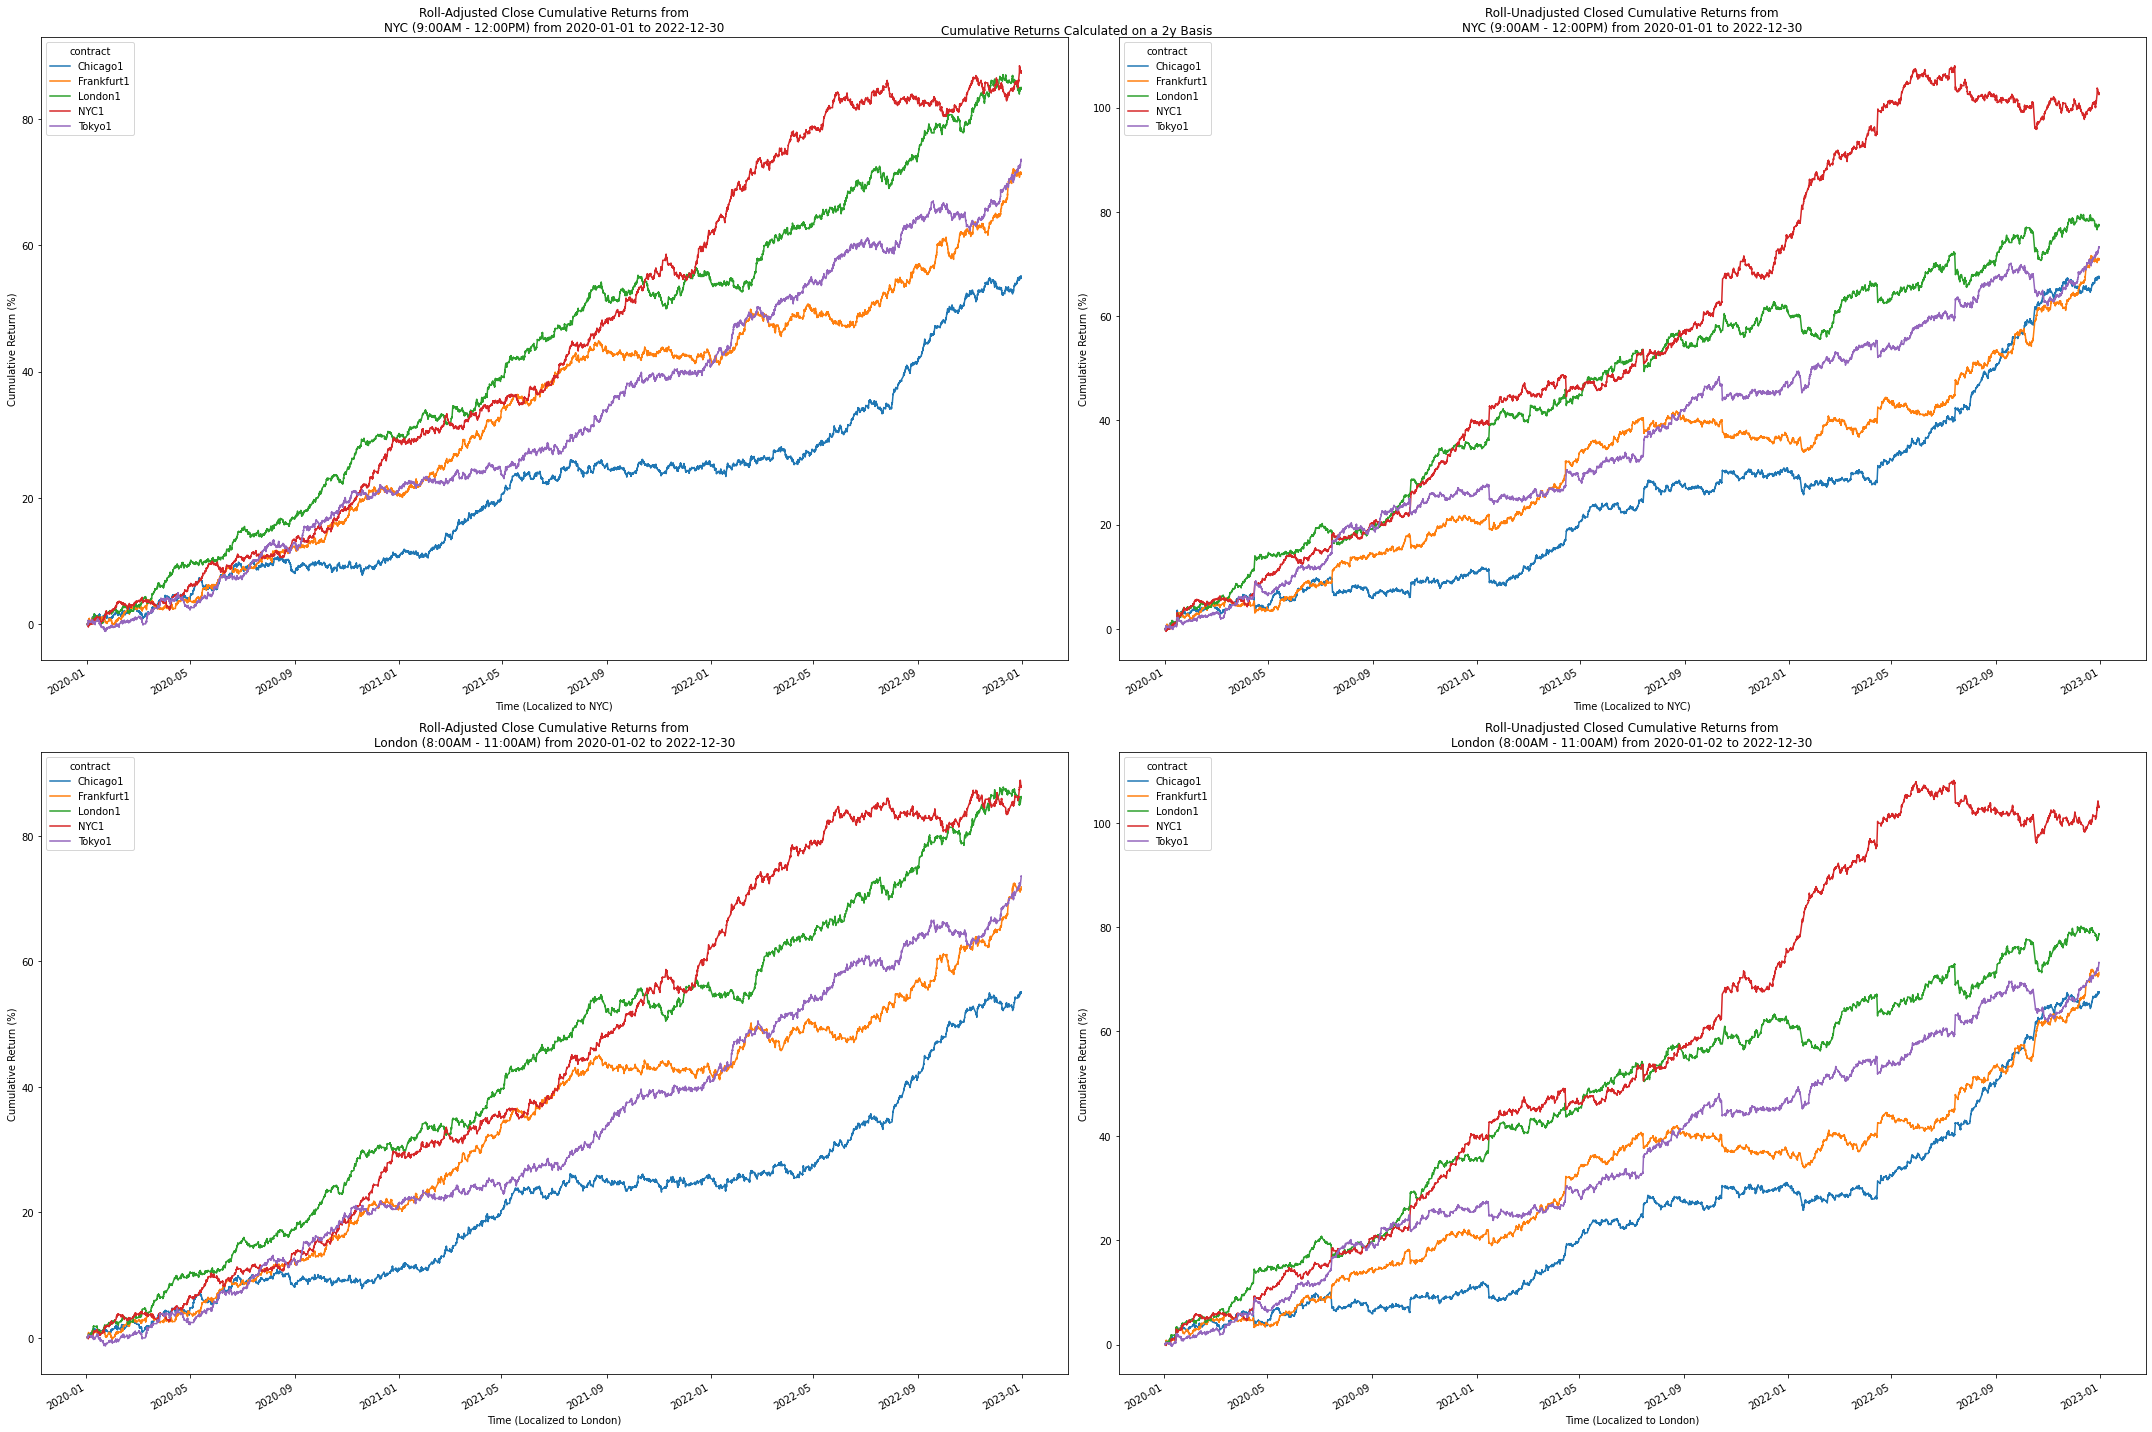

In [16]:
rolls = ["adj", "unadj"]
roll_renamer = {"adj": "Roll-Adjusted Close", "unadj": "Roll-Unadjusted Closed"}
fig, axes = plt.subplots(ncols = len(rolls), nrows = 2, figsize = (30,20))

for i, roll in enumerate(rolls):
    
    (df_nyc_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "nyc_time", columns = "contract", values = "value").
        plot(
            ax = axes[0,i],
            xlabel = "Time (Localized to NYC)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nNYC (9:00AM - 12:00PM) from {} to {}".format(
                roll_renamer[roll],
                df_nyc_cum_rtn.nyc_time.min().date(),
                df_nyc_cum_rtn.nyc_time.max().date())))
    
    (df_london_cum_rtn.assign(
        value = lambda x: x.value * 100).
        query("roll == @roll").
        drop(columns = ["roll"]).
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "london_time", columns = "contract", values = "value").
        plot(
            ax = axes[1,i],
            xlabel = "Time (Localized to London)",
            ylabel = "Cumulative Return (%)",
            title = "{} Cumulative Returns from\nLondon (8:00AM - 11:00AM) from {} to {}".format(
                roll_renamer[roll],
                df_london_cum_rtn.london_time.min().date(),
                df_london_cum_rtn.london_time.max().date())))
    
fig.suptitle("Cumulative Returns Calculated on a 2y Basis")
plt.tight_layout()
plt.show()

# Cumulative Buy and Sell Volume

There is a problem. Volume is sample from normal distribution as values begin to get cumulative summed CLT comes into play and thus cumulative sum ends up looking like a straight line. 

In [17]:
min_year = 2020
df_nyc_vol = (df_raw.query(
    "market_hour == 'open'")
    [["contract_name", "nyc_time", "buy_vol", "sell_vol"]].
    assign(
        date = lambda x: x.nyc_time.dt.date,
        hour = lambda x: x.nyc_time.dt.hour,
        year = lambda x: x.nyc_time.dt.year).
    query("year >= @min_year & hour >= 9 & hour <= 12").
    drop(columns = ["hour", "year", "nyc_time"]).
    melt(id_vars = ["contract_name", "date"]).
    query("value != 0").
    groupby(["contract_name", "date", "variable"]).
    agg("sum").
    reset_index().
    pivot(index = ["contract_name", "date"], columns = ["variable"], values = "value").
    reset_index())

In [18]:
df_london_vol = (df_raw.query(
    "zone == 'London'")
    [["nyc_time", "local_time"]].
    rename(columns = {"local_time": "london_time"}).
    merge(
        right = df_raw[["local_time", "nyc_time", "buy_vol", "sell_vol", "contract_name"]], 
        how = "inner", 
        on = ["nyc_time"]).
    drop(columns = ["nyc_time", "local_time"]).
    assign(
        date = lambda x: x.london_time.dt.date,
        hour = lambda x: x.london_time.dt.hour,
        year = lambda x: x.london_time.dt.year).
    query("year >= @min_year & hour >= 8 & hour <= 11").
    drop(columns = ["year", "hour", "london_time"]).
    melt(id_vars = ["contract_name", "date"]).
    query("value != 0").
    groupby(["contract_name", "date", "variable"]).
    agg("sum").
    reset_index().
    pivot(index = ["contract_name", "date"], columns = "variable", values = "value").
    reset_index())

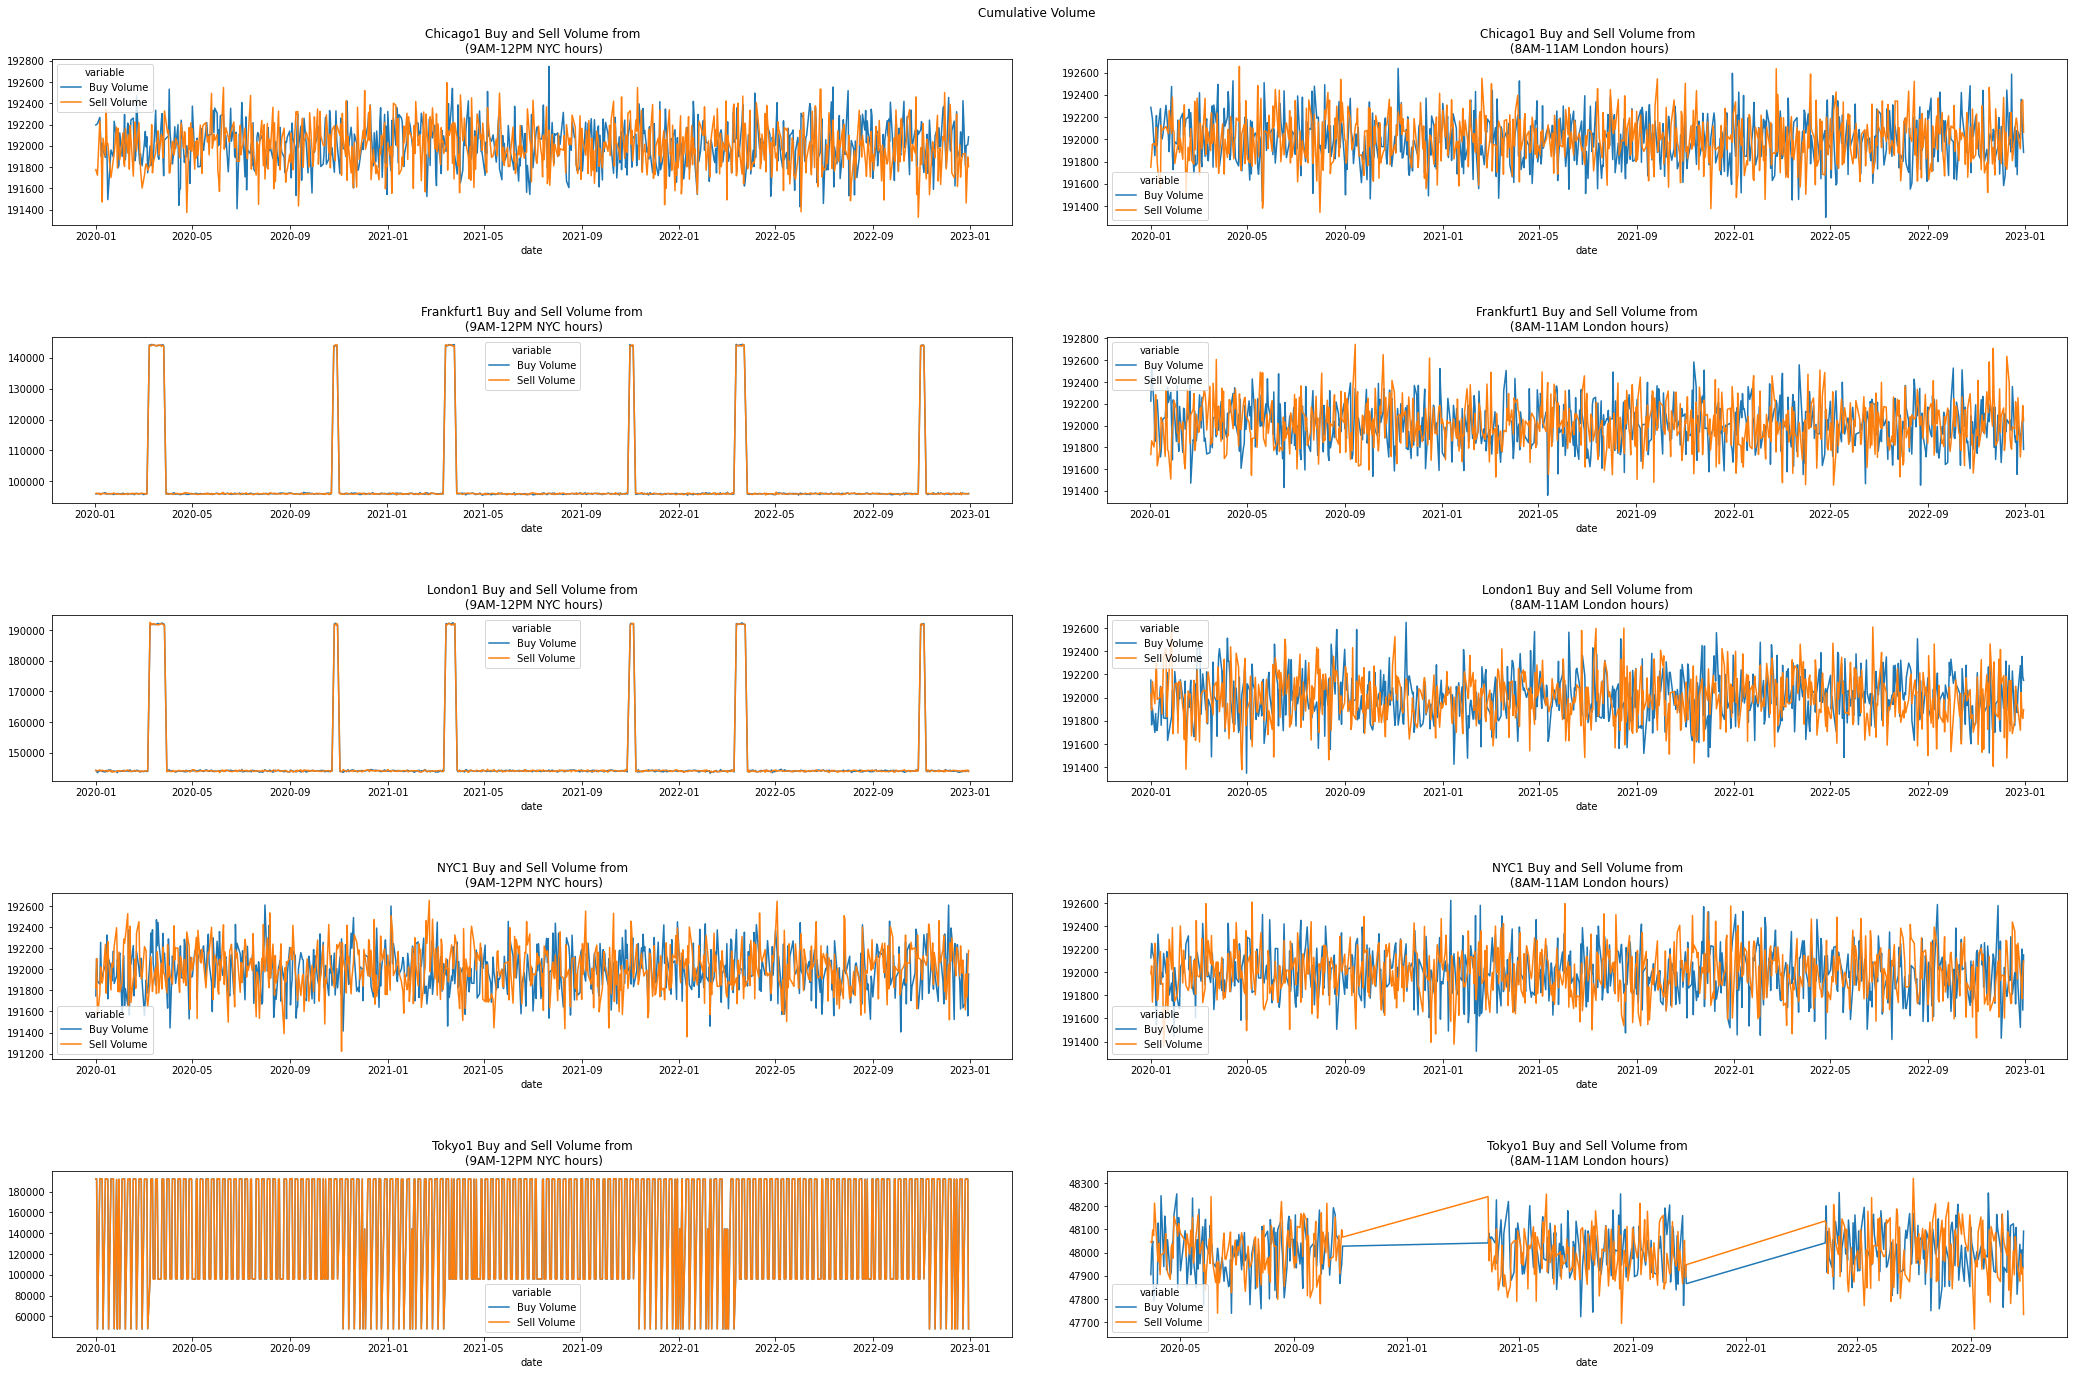

In [19]:
contracts = df_london_vol.contract_name.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 2, nrows = len(contracts), figsize = (30,20))

for i, contract in enumerate(contracts):
    
    (df_nyc_vol.query(
        "contract_name == @contract").
        drop(columns = ["contract_name"]).
        set_index("date").
        rename(columns = {
            "buy_vol": "Buy Volume",
            "sell_vol": "Sell Volume"}).
        plot(
            ax = axes[i,0],
            title = "{} Buy and Sell Volume from\n (9AM-12PM NYC hours)".format(contract)))
    
    (df_london_vol.query(
        "contract_name == @contract").
        drop(columns = ["contract_name"]).
        set_index("date").
        rename(columns = {
            "buy_vol": "Buy Volume",
            "sell_vol": "Sell Volume"}).
        plot(
            ax = axes[i,1],
            title = "{} Buy and Sell Volume from\n (8AM-11AM London hours)".format(contract)))
    
fig.suptitle("Cumulative Volume")
plt.tight_layout(pad = 5)

# Average True Range

In [20]:
market_stats.get_roll_adjusted_prices()
df_adj_price = market_stats.df_prices_adj

roll adjusted prices saved as attribute df_prices_adj


In [21]:
def _get_true_nyc_range(df: pd.DataFrame) -> pd.DataFrame:
    
    low_price = (df.query("low_price == low_price.min()").low_price.iloc[0])
    high_price = (df.query("high_price == high_price.max()").high_price.iloc[0])
    close_price = (df.query("nyc_time == nyc_time.max()").close_price.iloc[0])
    
    return(pd.DataFrame({
        "high_price": [high_price],
        "low_price": [low_price],
        "close_price": [close_price]}))

def _get_true_london_range(df: pd.DataFrame) -> pd.DataFrame:
    
    low_price = (df.query("low_price == low_price.min()").low_price.iloc[0])
    high_price = (df.query("high_price == high_price.max()").high_price.iloc[0])
    close_price = (df.query("london_time == london_time.max()").close_price.iloc[0])
    
    return(pd.DataFrame({
        "high_price": [high_price],
        "low_price": [low_price],
        "close_price": [close_price]}))

def _rolling_ma(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return(df.sort_values(
        "date").
        assign(rolling_ma = lambda x: x.true_range.rolling(window = window).mean()).
        dropna())

In [22]:
min_year = 2022

In [23]:
df_nyc_ma = (df_adj_price.merge(
    right = df_raw.query("zone == 'NYC'")[["local_time", "nyc_time"]],
    how = "inner",
    on = ["local_time"]).
    drop(columns = ["local_time"]).
    assign(hour = lambda x: x.nyc_time.dt.hour).
    query("hour >= 9 & hour <= 12").
    assign(year = lambda x: x.nyc_time.dt.year).
    query("year >= @min_year").
    drop(columns = ["hour", "year"]).
    melt(id_vars = ["contract_name", "nyc_time", "field"]).
    pivot(index = ["contract_name", "nyc_time", "variable"], columns = "field", values = "value").
    reset_index().
    assign(date = lambda x: x.nyc_time.dt.date).
    groupby(["contract_name", "date", "variable"]).
    apply(_get_true_nyc_range).
    reset_index().
    assign(true_range = lambda x: (x.high_price - x.low_price) / x.close_price).
    reset_index()
    [["contract_name", "date", "true_range", "variable"]].
    groupby(["contract_name", "variable"]).
    apply(_rolling_ma).
    reset_index(drop = True))

In [24]:
df_london_ma = (df_raw.query(
    "zone == 'London'")
    [["nyc_time", "local_time"]].
    rename(columns = {"local_time": "london_time"}).
    merge(
        right = df_raw[["nyc_time", "local_time"]],
        how = "inner",
        on = ["nyc_time"]).
    drop(columns = ["nyc_time"]).
    merge(right = df_adj_price, how = "inner", on = ["local_time"]).
    drop(columns = ["local_time"]).
    assign(
        year = lambda x: x.london_time.dt.year,
        hour = lambda x: x.london_time.dt.hour).
    query("year >= @min_year & hour >= 8 & hour <= 12").
    drop(columns = ["year", "hour"]).
    melt(id_vars = ["london_time", "contract_name", "field"]).
    groupby(["london_time", "contract_name", "field", "variable"]).
    head(1).
    pivot(index = ["london_time", "contract_name", "variable"], columns = "field", values = "value").
    reset_index().
    assign(date = lambda x: x.london_time.dt.date).
    groupby(["contract_name", "date", "variable"]).
    apply(_get_true_london_range).
    reset_index().
    assign(true_range = lambda x: (x.high_price - x.low_price) / x.close_price).
    reset_index()
    [["contract_name", "date", "true_range", "variable"]].
    groupby(["contract_name", "variable"]).
    apply(_rolling_ma).
    reset_index(drop = True))

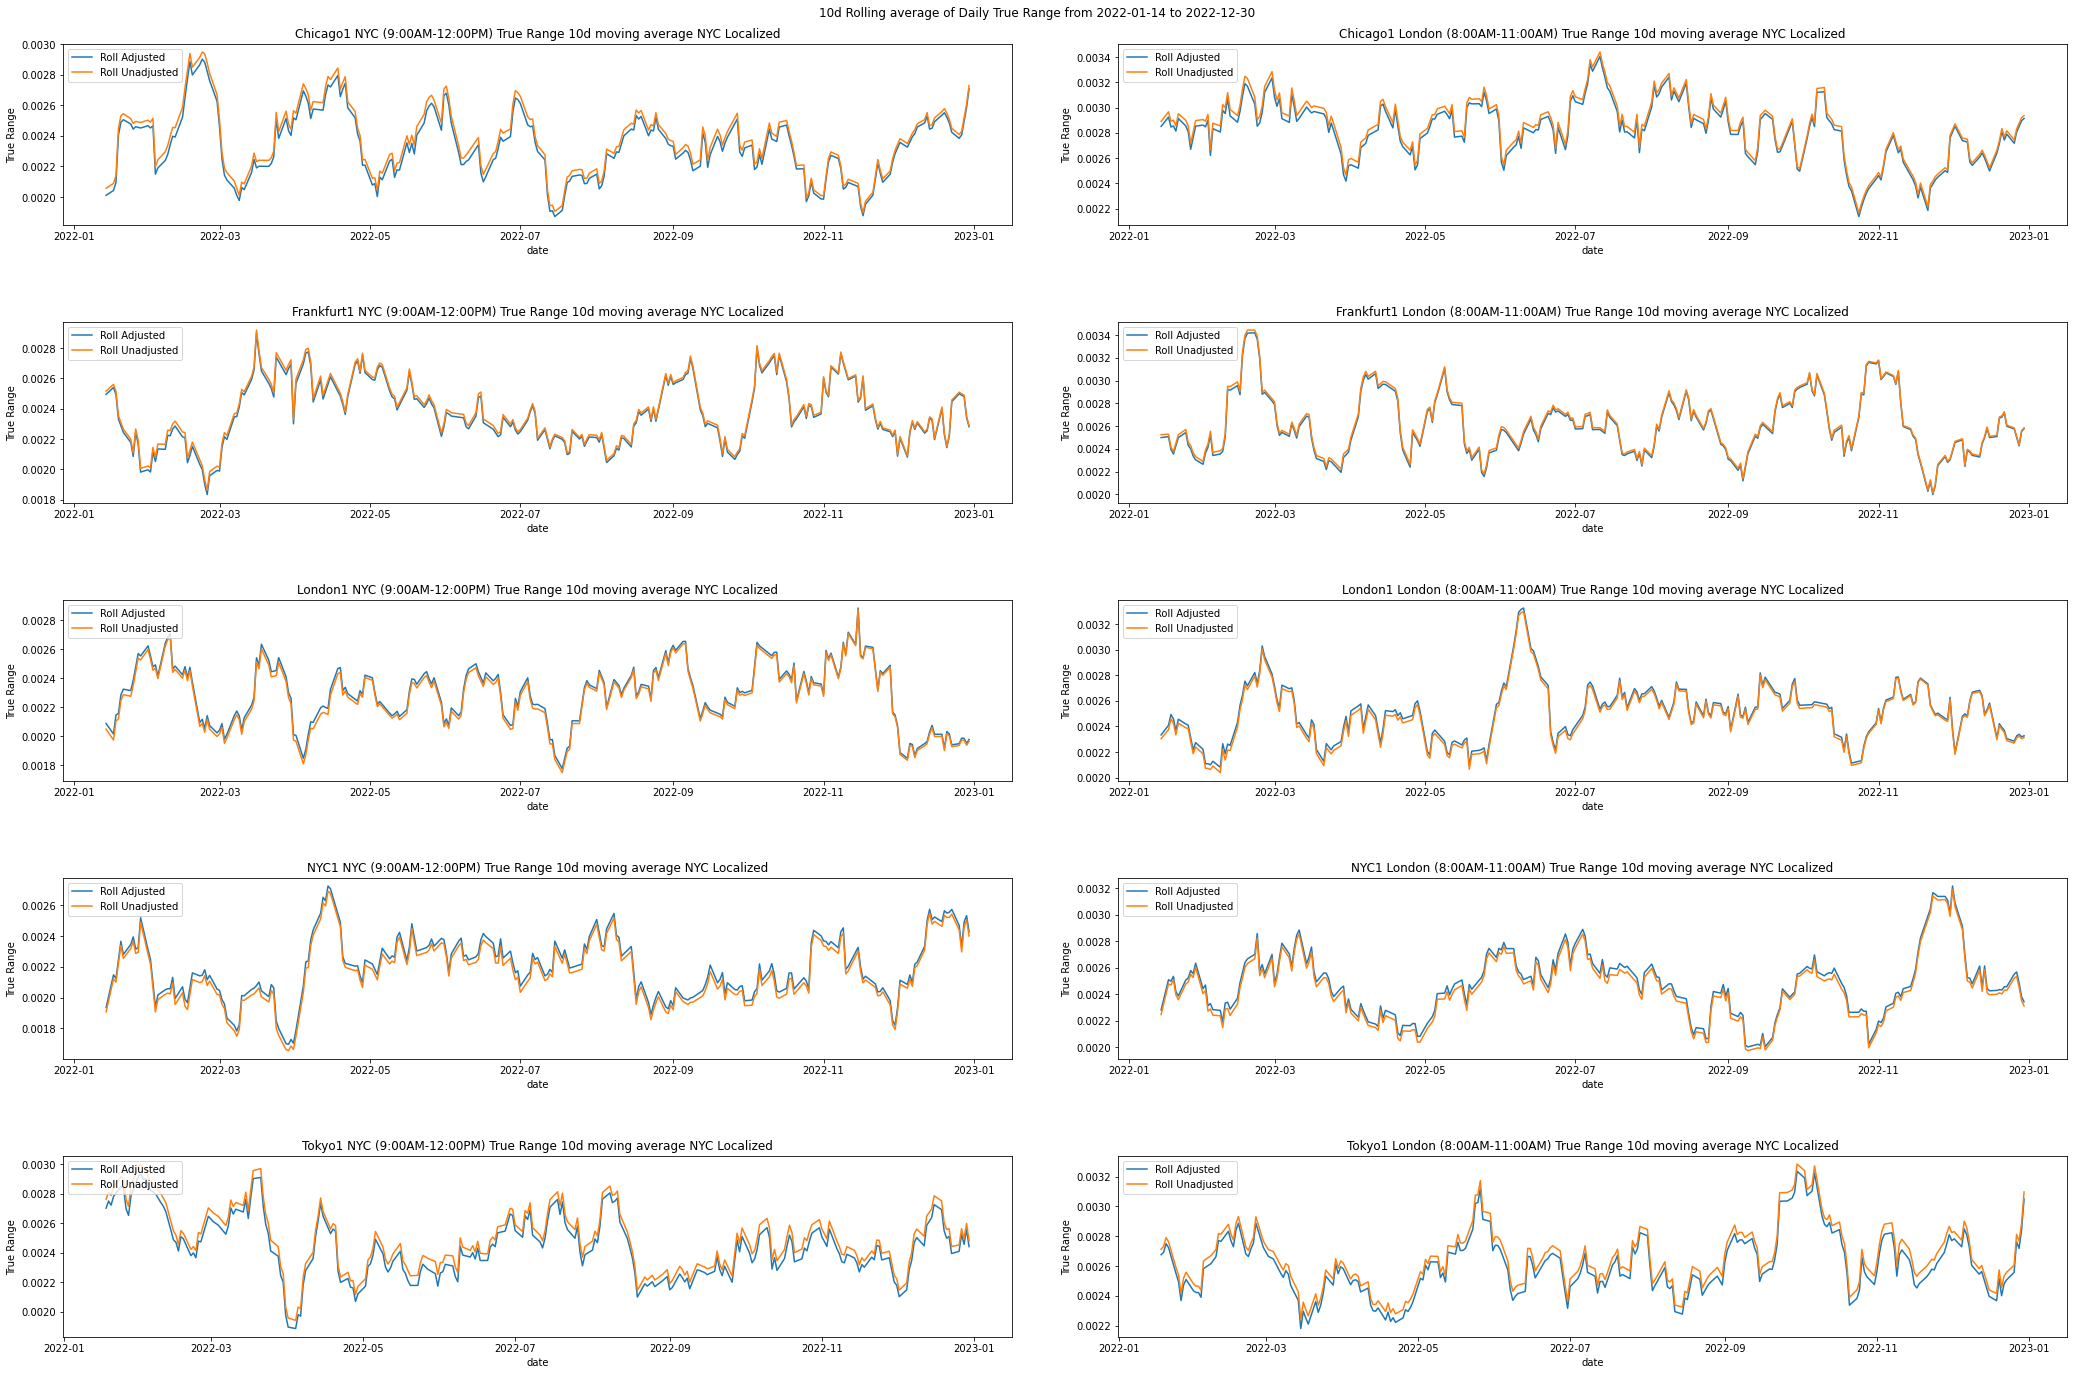

In [25]:
#### contracts = df_london_ma.contract_name.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 2, nrows = len(contracts), figsize = (30,20))

for i, contract in enumerate(contracts):
    
    (df_nyc_ma.query(
        "contract_name == @contract").
        drop(columns = ["contract_name", "true_range"]).
        pivot(index = "date", columns = ["variable"], values = "rolling_ma").
        rename(columns = {
            "adj": "Roll Adjusted",
            "unadj": "Roll Unadjusted"}).
        plot(
            ax = axes[i,0],
            title = "{} NYC (9:00AM-12:00PM) True Range 10d moving average NYC Localized".format(contract),
            ylabel = "True Range"))
    
    axes[i,0].legend(loc = "upper left")
    
    (df_london_ma.query(
        "contract_name == @contract").
        drop(columns = ["contract_name", "true_range"]).
        pivot(index = "date", columns = ["variable"], values = "rolling_ma").
        rename(columns = {
            "adj": "Roll Adjusted",
            "unadj": "Roll Unadjusted"}).
        plot(
            ax = axes[i,1],
            title = "{} London (8:00AM-11:00AM) True Range 10d moving average NYC Localized".format(contract),
            ylabel = "True Range"))
    
    axes[i,1].legend(loc = "upper left")
    
fig.suptitle("10d Rolling average of Daily True Range from {} to {}".format(
    df_nyc_ma.date.min(),
    df_nyc_ma.date.max()))

plt.tight_layout(pad = 5)